<h1>Introduction</h1>

<p style="text-align:justify">This project aims to create an image classifier neural network through transfer-learning and InceptionV3 for classification of whether a person has cataract or not. This project is the final submission for Deep Learning Developer: Jump Start January 01 Workshop. The dataset is created by using Google images of cataract and Fatkun (an image batch download extension).
</p>


<h1>Testing for GPU</h1>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


<h1>Download the Dataset</h1>

In [0]:
!ls

sample_data


In [0]:
!wget -qq https://www.dropbox.com/s/omp5qzb0ciqceep/DataSet.zip
  
!unzip -qq DataSet.zip
!rm DataSet.zip

!ls

DataSet  __MACOSX  sample_data


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt


import os, json
from glob import glob
import numpy as np
import keras

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

Using TensorFlow backend.


In [0]:
print(tf.__version__)
print(tf.keras.__version__)
print(keras.__version__)

1.12.0
2.1.6-tf
2.2.4


In [0]:
!ls DataSet

Cataract  No_Cataract


<h1>Prepare Dataset</h1>

In [0]:
# Set up some Hyperparameters

batch_size = 32
epochs = 10

lr = 0.001

In [0]:
import glob
import pandas as pd

cataract = glob.glob('./DataSet/Cataract/*.jpg')
no_cataract = glob.glob('./DataSet/No_Cataract/*.jpg')


names = ['cataract', 'no cataract']


len(cataract)

86

In [0]:
len(no_cataract)

67

In [0]:
cataract[:10]

['./DataSet/Cataract/800wm.jpg',
 './DataSet/Cataract/advanced_cataract_question.jpg',
 './DataSet/Cataract/cataract (4).jpg',
 './DataSet/Cataract/1_LRG_BK.jpg',
 './DataSet/Cataract/S_1217_agre_related_cataract_M1550.2e16d0ba.fill_920x613.jpg',
 './DataSet/Cataract/princ_rm_photo_of_close_up_of_eye (1).jpg',
 './DataSet/Cataract/Fig_1_etiji_2 2.jpg',
 './DataSet/Cataract/250px_Dense_white_mature_cataract.jpg',
 './DataSet/Cataract/sub_pic23.jpg',
 './DataSet/Cataract/A_dense_white_cataract_made_visible_by_pupil_dilation.jpg']

In [0]:
# Make a dataframe based on the filenames
df = pd.DataFrame(cataract, columns = ["filename"])
df2 = pd.DataFrame(no_cataract, columns = ["filename"])

# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)


# Split into train and validation sets
train_set_percentage = .9


train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]



df_new_train = pd.concat([train_df, train_df2])
df_new_val = pd.concat([val_df, val_df2])

# shuffle 
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [0]:
df.head()

,filename,class
0,./DataSet/No_Cataract/GettyImages_807375618_0.jpg,1
1,./DataSet/No_Cataract/eye_2792062b.jpg,1
2,./DataSet/Cataract/slideshowc5.jpg,0
3,./DataSet/Cataract/001.jpg,0
4,./DataSet/Cataract/advanced_cataract_question.jpg,0


In [0]:
print(df.shape)
print(df_val.shape)

df['class'].unique()

(137, 2)
(16, 2)


array([1, 0])

0    77
1    60
Name: class, dtype: int64


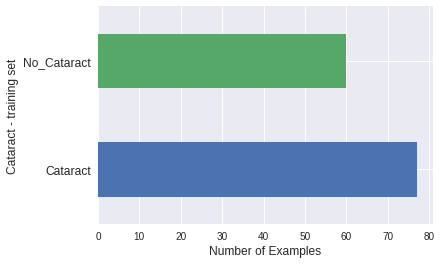

In [0]:
print(df['class'].value_counts())


ax = df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Cataract - training set", fontsize=12)
ax.set_yticklabels(['Cataract','No_Cataract'], rotation=0, fontsize=12)
plt.show()

In [0]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2

df.shape

(137, 2)

<h1>Make the Pipeline for loading and resizing the images</h1>

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

<h1>Assembling the Data pipeline using tf.data</h1>

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(16, drop_remainder=True)

<h1>Choosing the pre-trained network for Transfer Learning</h1>

In [0]:
# InceptionV3 Model - trained on image net
base_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

<h1>Create a simple head for the model that we can train</h1>

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)


# 2 Classes for cataract
predictions = Dense(num_classes, activation='softmax')(x)

In [0]:
# Creating the model that we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# Freeze the InceptionV3 layers except the BatchNorm
for layer in base_model.layers:
    if 'batch' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 

batch_normalization
batch_normalization_1
batch_normalization_2
batch_normalization_3
batch_normalization_4
batch_normalization_8
batch_normalization_6
batch_normalization_9
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
batch_normalization_15
batch_normalization_13
batch_normalization_16
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
batch_normalization_22
batch_normalization_20
batch_normalization_23
batch_normalization_19
batch_normalization_21
batch_normalization_24
batch_normalization_25
batch_normalization_27
batch_normalization_28
batch_normalization_26
batch_normalization_29
batch_normalization_34
batch_normalization_35
batch_normalization_31
batch_normalization_36
batch_normalization_32
batch_normalization_37
batch_normalization_30
batch_normalization_33
batch_normalization_38
batch_normalization_39
batch_normalization_44
batch_normalization_45
batch_normalization_41
batch_normalization_46


In [0]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d
False
batch_normalization
True
activation
False
conv2d_1
False
batch_normalization_1
True
activation_1
False
conv2d_2
False
batch_normalization_2
True
activation_2
False
max_pooling2d
False
conv2d_3
False
batch_normalization_3
True
activation_3
False
conv2d_4
False
batch_normalization_4
True
activation_4
False
max_pooling2d_1
False
conv2d_8
False
batch_normalization_8
True
activation_8
False
conv2d_6
False
conv2d_9
False
batch_normalization_6
True
batch_normalization_9
True
activation_6
False
activation_9
False
average_pooling2d
False
conv2d_5
False
conv2d_7
False
conv2d_10
False
conv2d_11
False
batch_normalization_5
True
batch_normalization_7
True
batch_normalization_10
True
batch_normalization_11
True
activation_5
False
activation_7
False
activation_10
False
activation_11
False
mixed0
False
conv2d_15
False
batch_normalization_15
True
activation_15
False
conv2d_13
False
conv2d_16
False
batch_normalization_13
True
batch_normalization_16
True
activation_13
False
act

<h1>Select an Optimizer and Compile the Model</h1>

In [0]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

# compile the model 

model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

<h1>Callbacks</h1>

In [0]:
!mkdir checkpoints


checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

In [0]:
train_steps = 100
val_steps = 50
epochs = 5

<h1>Fitting the model</h1>

we pass in:

- The training set  
- the steps for how many times we want to sample a batch to be one epoch  
- number of epochs
- validation set
- number of steps for validation

In [0]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Epoch 1/5
 99/100 [============================>.] - ETA: 1s - loss: 0.2036 - acc: 0.9356
Epoch 00001: val_loss improved from inf to 0.17167, saving model to ./checkpoints/weights_01_0.88.hdf5
100/100 [==============================] - 183s 2s/step - loss: 0.2016 - acc: 0.9363 - val_loss: 0.1717 - val_acc: 0.8750
Epoch 2/5
 99/100 [============================>.] - ETA: 1s - loss: 8.9590e-04 - acc: 1.0000
Epoch 00002: val_loss did not improve from 0.17167
100/100 [==============================] - 120s 1s/step - loss: 8.9012e-04 - acc: 1.0000 - val_loss: 0.1830 - val_acc: 0.8750
Epoch 3/5
 99/100 [============================>.] - ETA: 1s - loss: 2.3791e-04 - acc: 1.0000
Epoch 00003: val_loss did not improve from 0.17167
100/100 [==============================] - 121s 1s/step - loss: 2.3687e-04 - acc: 1.0000 - val_loss: 0.1864 - val_acc: 0.9375
Epoch 4/5
 99/100 [============================>.] - ETA: 1s - loss: 1.0171e-04 - acc: 1.0000
Epoch 00004: val_loss improved from 0.17167 to 0.

In [0]:
!ls checkpoints

weights_01_0.88.hdf5  weights_04_0.94.hdf5  weights_05_0.94.hdf5


In [0]:
model.load_weights('./checkpoints/weights_04_0.94.hdf5')

In [0]:
metrics = model.evaluate(valid_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 18s 355ms/step
model accuracy: 0.9375


In [0]:
preds = model.predict(test_dataset,steps=1)
preds = preds.argmax(axis=-1)

preds.shape

(16,)

In [0]:
test_labels = val_labels_list[0:16]

len(test_labels)

16

<h1>Make a Confusion Matrix</h1>

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix
[[0.88888889 0.11111111]
 [0.         1.        ]]


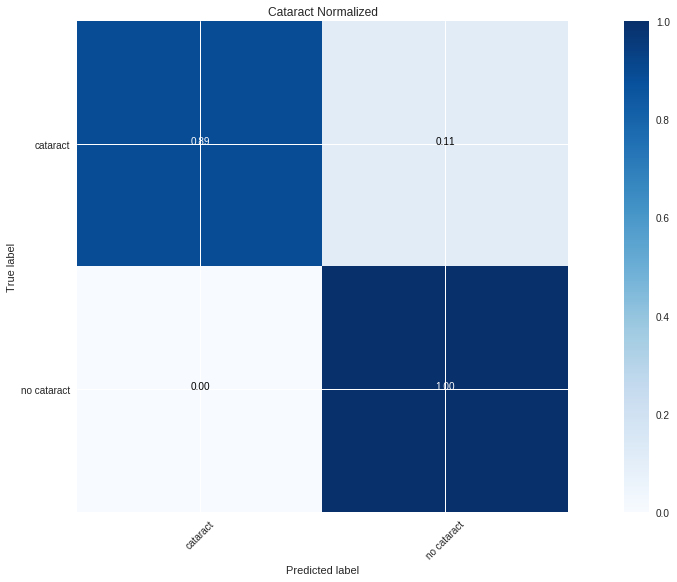

In [0]:
cm_plot_labels = names

# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Cataract Normalized')

plt.show()

<h1>Save the Model and weights</h1>

In [0]:
model.save('cataract.h5')

In [0]:
model.save_weights('cataract_weights.h5', save_format='h5')

In [0]:
model.save_weights('./cataract_tf')


Consider using a TensorFlow optimizer from `tf.train`.


<h1>Make a Prediction</h1>

In [0]:
!rm -rf TestSet

In [0]:
!wget -qq https://www.dropbox.com/s/58vmyuqvycmz2cy/TestSet.zip
  
!unzip -qq TestSet.zip
!rm TestSet.zip

In [0]:
image_path = './TestSet/'

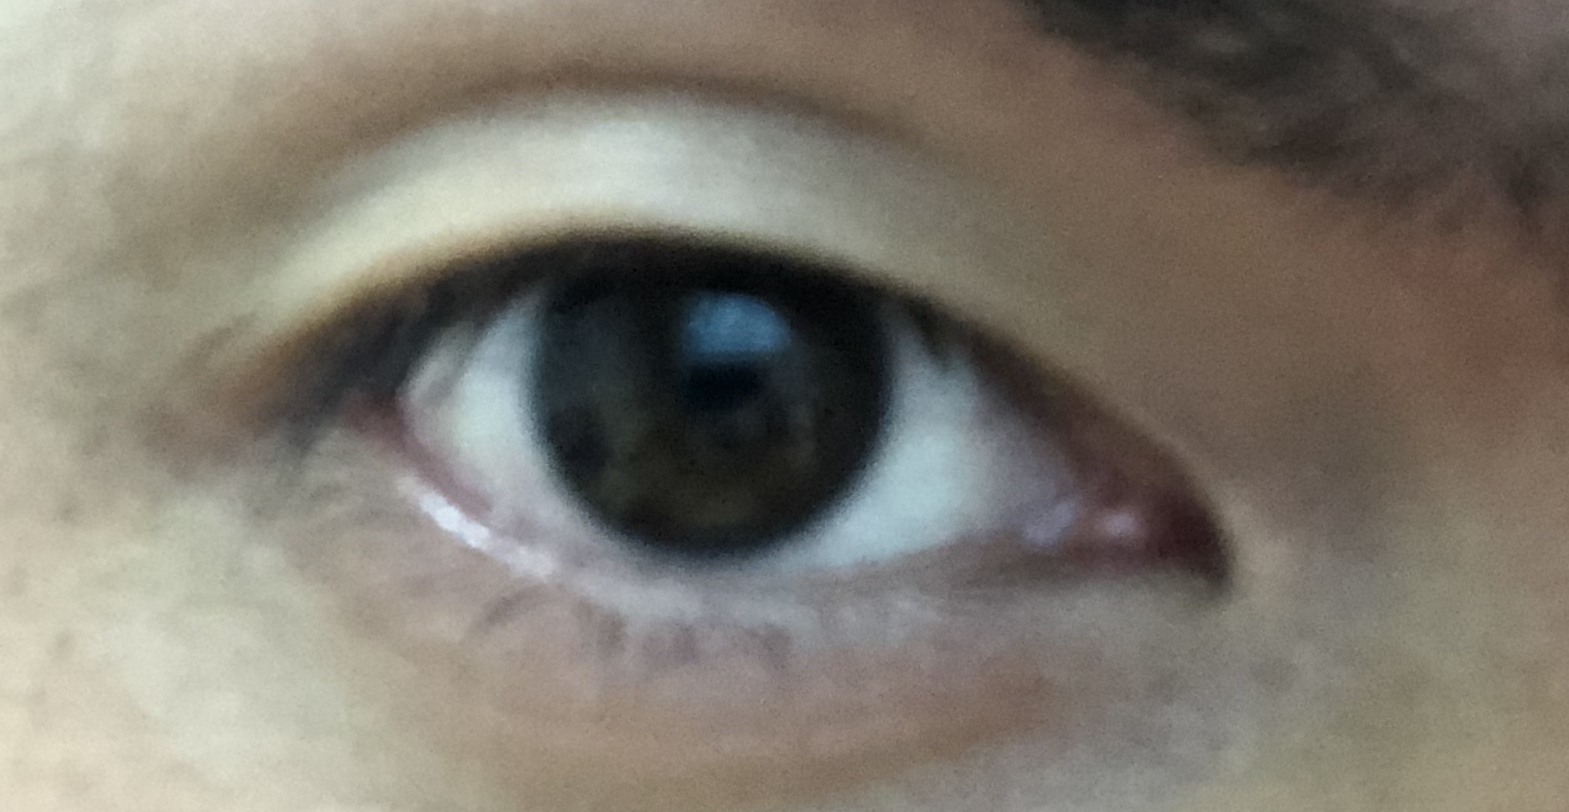

In [0]:
from IPython.display import Image

image_name = 'IMG_9544.jpg'
Image(image_path + image_name)

In [0]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_name)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [0]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[0.06116565 0.93883437]]
1


In [0]:
result= np.argmax(pred)
if result==0:
    print("You have cataract")
else:
    print("You do not have cataract")

You do not have cataract


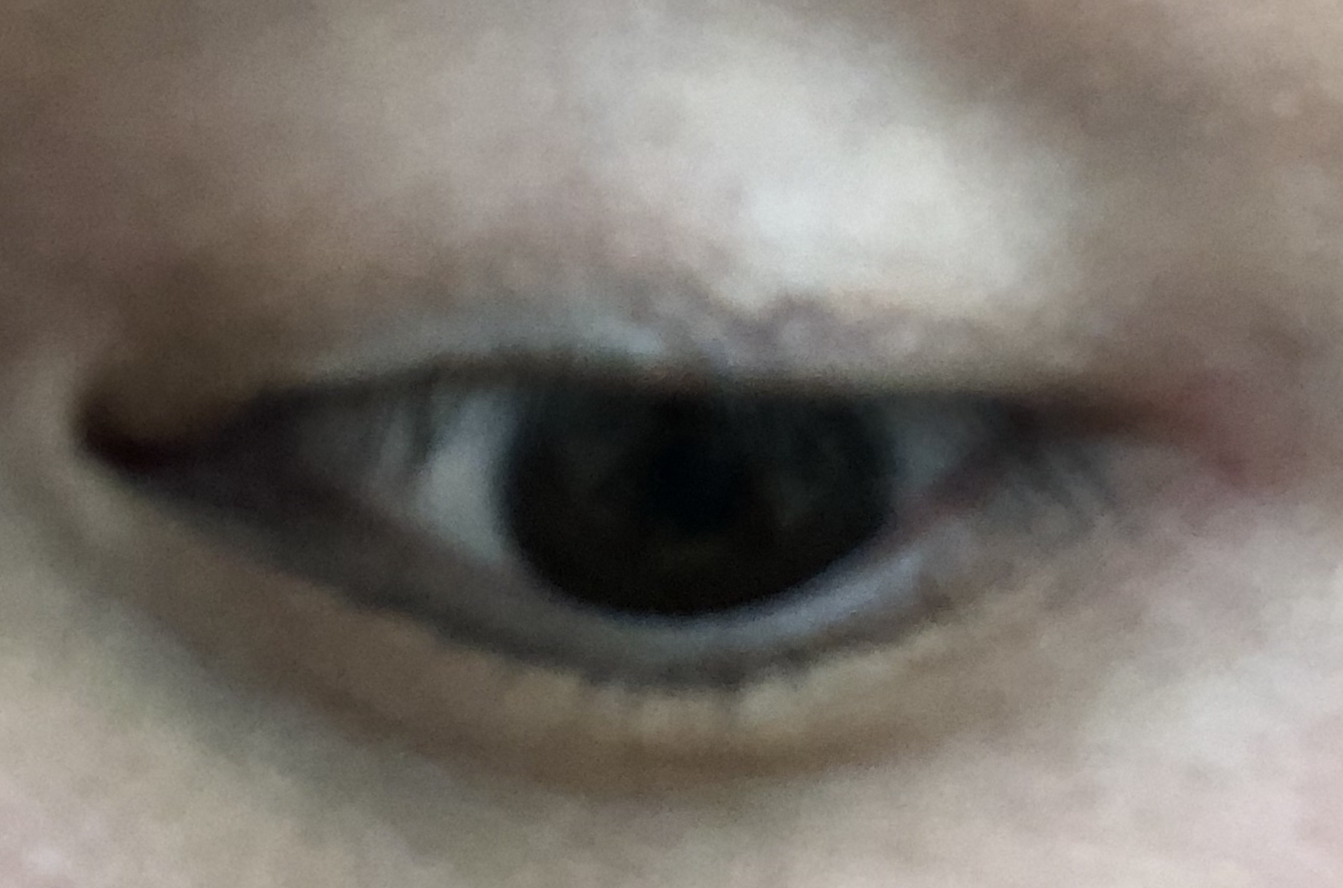

In [0]:
from IPython.display import Image

image_name = 'IMG_9547.jpg'
Image(image_path + image_name)

In [0]:
img_path = os.path.join(image_path, image_name)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [0]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[0.966669   0.03333092]]
0


In [0]:
result= np.argmax(pred)
if result==0:
    print("You have cataract")
else:
    print("You do not have cataract")

You have cataract


<h1>Conclusion</h1>

<p style="text-align:justify">The image classifer is able to predict confidently (with a result of 0.94) whether the person contracts cataract by image of his or her eye.</p>

<p style="text-align:justify">However, if the eye is half-closed or is glossy because of the light reflection, the neural network will diagnose the patient with cataract.</p>

<h1>Ways to improve</h1>

<p style="text-align:justify">The pre-trained model is currently used as a benchmark for the project, as such the model may be improved by changing the layers so that it does not overfit as seen from the number of epochs ran through the model. After the 2nd epoch, the accuracy remains at 1 and validation accuracy remains at 0.9375 after 3rd epoch.</p>